Mitigating drifts in the gains (deep scans)
====

This notebook shows how to mitigate some systematic effects. Especially we show that using this method we are able to reduce the effect of having drifts in time in the detector gains.

In [1]:
## Import basic modules and routines
from __future__ import division, absolute_import, print_function

## In case you did not install properly the library 
## or didn't update your bashrc. (Do it later!)
import os
path_to_s4cmb = '../../s4cmb'
os.sys.path.insert(0, os.path.realpath(path_to_s4cmb))

import healpy as hp
import pylab as pl
import numpy as np

## Import modules and routines from s4cmb
from s4cmb.input_sky import HealpixFitsMap

from s4cmb.instrument import Hardware

from s4cmb.scanning_strategy import ScanningStrategy

from s4cmb.tod import TimeOrderedDataPairDiff
from s4cmb.tod import OutputSkyMap
from s4cmb.tod import OutputSkyMapIGQU
from s4cmb.tod import partial2full
from s4cmb.tod import psdts

from s4cmb.systematics import step_function_gen
from s4cmb.systematics import linear_function_gen

try:
    from tqdm import *
except ImportError:
    tqdm = lambda x: x

Flow is the following: sky + instrument + scanning strategy --> map2tod --> create gain drift --> tod2map.

Initialise our instrument, scanning strategy and input maps as seen in the Day 1 lectures. 

In [2]:
## Instrument
inst = Hardware(ncrate=4, ndfmux_per_crate=1,
                nsquid_per_mux=1, npair_per_squid=16,
                fp_size=60., fwhm=3.5, 
                beam_seed=58347, projected_fp_size=3., pm_name='5params',
                type_hwp='CRHWP', freq_hwp=2., angle_hwp=0., verbose=False)

## Input maps
nside = 512
path_to_cls = '../../s4cmb/s4cmb/data/test_data_set_lensedCls.dat'
sky_in = HealpixFitsMap(path_to_cls, do_pol=True, 
                        fwhm_in=inst.beam_model.fwhm, nside_in=nside, 
                        map_seed=5843787, verbose=False, 
                        no_ileak=False, no_quleak=False)

## Scanning strategy
scan = ScanningStrategy(nces=12, start_date='2013/1/1 00:00:00',
                        telescope_longitude='-67:46.816',
                        telescope_latitude='-22:56.396', telescope_elevation=5200.,
                        name_strategy='deep_patch', sampling_freq=8., sky_speed=0.4,
                        ut1utc_fn='../../s4cmb/s4cmb/data/ut1utc.ephem', 
                        language='fortran')
scan.run()

We break the timestream every hour (one CES is here 4 hours).
We inject $\pm$ 5% drift (linear) centered around gain=1.

** Classic way **

This is what was used so far. The idea is to combine two bolometers from the same pair, having orthogonal polarisation:

$$\begin{align}
d_{top} &= I + Q \cos(2\theta_{par} + 4\theta_{HWP}) + U \sin(2\theta_{par} + 4\theta_{HWP}) \\
d_{bottom} &= I - Q \cos(2\theta_{par} + 4\theta_{HWP}) - U \sin(2\theta_{par} + 4\theta_{HWP})
\end{align}$$

Adding or subtracting them let have access to temperature or polarisation respectively:

$$\begin{align}
d_{+} &= \dfrac{d_{top} + d_{bottom}}{2} = I \\
d_{-} &= \dfrac{d_{top} - d_{bottom}}{2} = Q \cos(2\theta_{par} + 4\theta_{HWP}) + U \sin(2\theta_{par} + 4\theta_{HWP}) 
\end{align}$$

** G deprojection **

In order to have a better control of the unwanted scan-synchronous signals in the polarized timestreams (difference of the two bolometers within a pair $p$), we use a slightly different version data model as the one presented above.
Let's model $d_{top/bottom}$ the two orthogonal timestream data inside a pair as

\begin{equation}
d_{top/bottom} = I \pm G \pm Q \cos(2\theta_{par} + 4\theta_{HWP}) \pm U \sin(2\theta_{par} + 4\theta_{HWP})
\end{equation}

where G is a map which contains contributions from the polarized timestreams (G vanishes if we sum the timestreams) which are not modulated by the polarization angle $2\theta_{par} + 4\theta_{HWP}$ (any intensity to polarization leakage for instance)\footnote{Despite the same name, this G has nothing to do with the ground template defined earlier.}.
In the presence of $G$, the pointing matrix is modified (4 non-zero components entries for each row corresponding to time $t$), and the pixel inverse covariance matrix is extended as

\begin{align}
&( \textbf{A}^{T} \textbf{N}^{-1} \textbf{A} )_p = \nonumber \\
&\displaystyle \sum_{t\in p} \begin{pmatrix} 
 \sigma^{-2}_{+} (t)  & 0 & 0 & 0\\
0 &  \sigma^{-2}_{+} (t)  & \sigma^{-2}_{-} (t) \cos 2\Theta (t) &  \sigma^{-2}_{-} (t) \sin 2\Theta (t) \\
0 &  \sigma^{-2}_{-} (t) \cos 2\Theta (t) &\sigma^{-2}_{-} (t) \cos^2 2\Theta (t)  &  \sigma^{-2}_{-} (t) \cos2\Theta (t) \sin2\Theta (t) \\ 
0 &  \sigma^{-2}_{-} (t) \sin 2\Theta (t) &   \sigma^{-2}_{-} (t) \cos2\Theta (t) \sin2\Theta (t) &  \sigma^{-2}_{-} (t) \sin^2 2\Theta (t) 
\end{pmatrix}_p,
\end{align}
where the lower [3x3] full block is the polarized part, including $G$, $Q$, and $U$, and $\Theta = \theta_{par} + 2\theta_{HWP}$.
The preconditioner is also updated accordingly.
Note that the correlation of $G$ maps with temperature maps can be used to estimate differential gain leakage or put upper limits on it. 

In [3]:
## Time-domain Noise level in [u]K.sqrt(s) for the whole array for one CES.
## Careful the units has to be the same as
## the input map! Note also that it corresponds to the polarisation level.
## This corresponds roughly to 10 uk.arcmin:
array_noise_level = 4.5

## Freeze initial seed, and define seeds for all scans
state_for_gain = np.random.RandomState(0)
seeds_for_gain = state_for_gain.randint(0, 1e6, scan.nces)

state_for_noise = np.random.RandomState(3)
seeds_for_noise = state_for_noise.randint(0, 1e6, scan.nces)

## Loop over scans
for CESnumber in range(scan.nces):
    ## Note that we specify that we want to map pairs
    ## one-by-one by setting mapping_perpair to True. This is 
    ## very useful if you have no det-to-det correlations and 
    ## you want to save memory by ot storing all timestreams
    ## in the memory.
    tod = TimeOrderedDataPairDiff(
        inst, scan, sky_in, CESnumber=CESnumber, 
        projection='healpix', 
        nside_out=nside, 
        width=130.,
        array_noise_level=array_noise_level,
        array_noise_seed=seeds_for_noise[CESnumber],
        mapping_perpair=True)
    
    ## Just for visualisation we also compute the result without contamination
    tod_perfect = TimeOrderedDataPairDiff(
        inst, scan, sky_in, CESnumber=CESnumber, 
        projection='healpix', 
        nside_out=nside, 
        width=130.,
        array_noise_level=array_noise_level,
        array_noise_seed=seeds_for_noise[CESnumber],
        mapping_perpair=True)
    
    ########################################################################
    ## Make new gain with 5% drift centered around 1, retuned every hour. ##
    ########################################################################
    new_gains_gen = linear_function_gen(tod.nsamples, 
                                        mean=1., 
                                        std=0.05, 
                                        nbreaks=4, 
                                        seed=seeds_for_gain[CESnumber])
    
    ## Initialise map containers
    if CESnumber == 0:
        ## Standard I, Q, and U
        skyIQU = OutputSkyMapIGQU(
            projection=tod.projection, 
            nside=tod.nside_out, 
            obspix=tod.obspix)
        
        ## Handle deprojection: I, G, Q, U
        skyIGQU = OutputSkyMapIGQU(
            projection=tod.projection, 
            nside=tod.nside_out, 
            obspix=tod.obspix)
        
        sky_perfect = OutputSkyMap(
            projection=tod.projection, 
            nside=tod.nside_out, 
            obspix=tod.obspix)
        
    ## Scan input map to get TODs
    ## Do it pair-by-pair to save memory for large runs.
    for pair in tqdm(tod.pair_list):
        ## Update the gains
        tod.set_detector_gains_perpair(new_gains=new_gains_gen.next())
        d = np.array([tod.map2tod(det) for det in pair])
        
        d_perfect = np.array([tod_perfect.map2tod(det) for det in pair])
        
        ## Project TOD to maps
        tod.tod2map(d, skyIQU, gdeprojection=False)
        tod.tod2map(d, skyIGQU, gdeprojection=True)
        tod_perfect.tod2map(d_perfect, sky_perfect)

  2%|▏         | 1/64 [00:00<00:17,  3.67it/s]

Pixels outside patch boundaries. Your output map will be cropped. To avoid this, increase the parameter width while initialising the TOD.


100%|██████████| 64/64 [00:22<00:00,  2.20it/s]


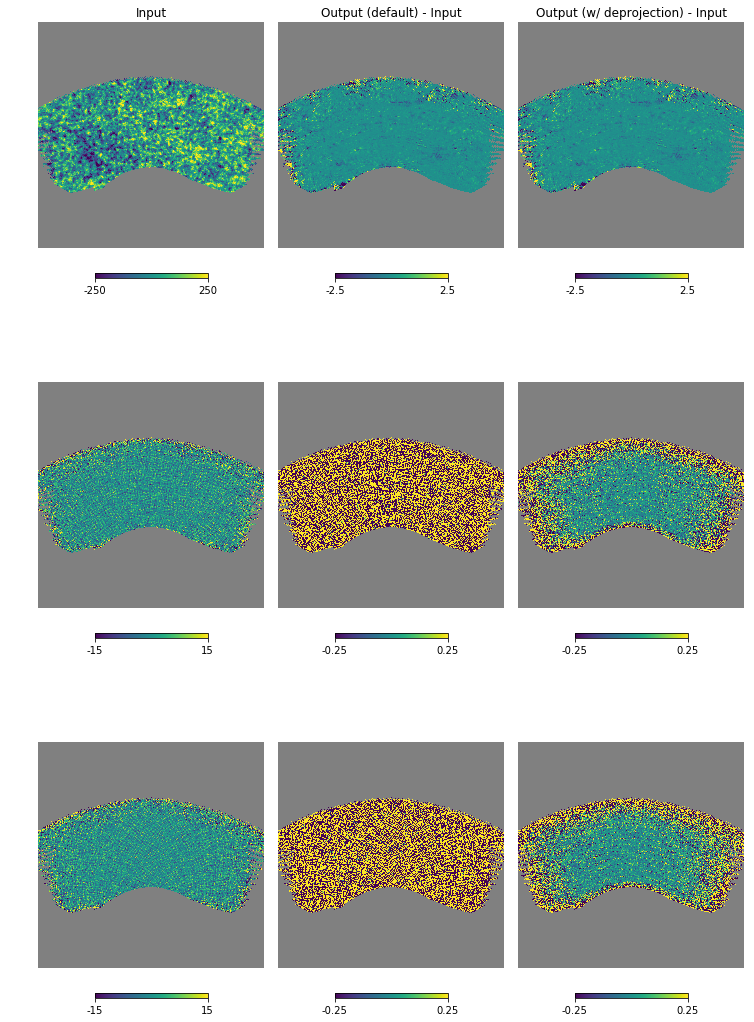

In [5]:
xsize = 700
fig = pl.figure(figsize=(10, 15))

nhit = partial2full(
    skyIQU.nhit, 
    skyIQU.obspix, 
    skyIQU.nside, fill_with=0.0)

## Temperature
sky_out_IQU = partial2full(
    skyIQU.get_I(), 
    skyIQU.obspix, 
    skyIQU.nside, fill_with=0.0)
sky_out_IGQU = partial2full(
    skyIGQU.get_I(), 
    skyIGQU.obspix, 
    skyIGQU.nside, fill_with=0.0)
sky_out_perfect = partial2full(
    sky_perfect.get_I(), 
    sky_perfect.obspix, 
    sky_perfect.nside, fill_with=0.0)

mask = nhit < 1
sky_out_IQU[mask] = np.nan
sky_out_IGQU[mask] = np.nan
sky_out_perfect[mask] = np.nan
hp.gnomview(sky_out_perfect, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=331, 
            title='Input', notext=True, min=-250, max=250)
hp.gnomview(sky_out_perfect - sky_out_IQU, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=332, 
            title='Output (default) - Input', notext=True, min=-2.5, max=2.5)
hp.gnomview(sky_out_perfect - sky_out_IGQU, rot=[0, -57.5], 
            xsize=xsize, reso=6.9, sub=333, 
            title='Output (w/ deprojection) - Input', notext=True, min=-2.5, max=2.5)

## Stokes Q
sky_out_IQU = partial2full(
    skyIQU.get_QU()[0], 
    skyIQU.obspix, 
    skyIQU.nside, fill_with=0.0)
sky_out_IGQU = partial2full(
    skyIGQU.get_QU()[1], 
    skyIGQU.obspix, 
    skyIGQU.nside, fill_with=0.0)
sky_out_perfect = partial2full(
    sky_perfect.get_QU()[0], 
    sky_perfect.obspix, 
    sky_perfect.nside, fill_with=0.0)

mask = nhit < 10
sky_out_IQU[mask] = np.nan
sky_out_IGQU[mask] = np.nan
sky_out_perfect[mask] = np.nan
hp.gnomview(sky_out_perfect, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=334, 
            notext=True, min=-15, max=15, title='')
hp.gnomview(sky_out_perfect - sky_out_IQU, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=335,  
            notext=True, min=-0.25, max=0.25, title='')
hp.gnomview(sky_out_perfect - sky_out_IGQU, rot=[0, -57.5], 
            xsize=xsize, reso=6.9, sub=336, 
            notext=True, title='', min=-0.25, max=0.25)

## Stokes U
sky_out_IQU = partial2full(
    skyIQU.get_QU()[1], 
    skyIQU.obspix, 
    skyIQU.nside, fill_with=0.0)
sky_out_IGQU = partial2full(
    skyIGQU.get_QU()[2], 
    skyIGQU.obspix, 
    skyIGQU.nside, fill_with=0.0)
sky_out_perfect = partial2full(
    sky_perfect.get_QU()[1], 
    sky_perfect.obspix, 
    sky_perfect.nside, fill_with=0.0)

mask = nhit < 10
sky_out_IQU[mask] = np.nan
sky_out_IGQU[mask] = np.nan
sky_out_perfect[mask] = np.nan
hp.gnomview(sky_out_perfect, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=337, 
            notext=True, min=-15, max=15, title='')
hp.gnomview(sky_out_perfect - sky_out_IQU, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=338, 
            notext=True, min=-0.25, max=0.25, title='')
hp.gnomview(sky_out_perfect - sky_out_IGQU, rot=[0, -57.5], 
            xsize=xsize, reso=6.9, sub=339, 
            notext=True, title='', min=-0.25, max=0.25)
pl.show()

Note that by construction, the deprojection is done only in polarisation.